<a href="https://colab.research.google.com/github/jungwoo1208/AI_Study/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn.functional as F
from typing import Optional, Callable, List, Type
from tqdm import tqdm

In [25]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("device: ", device)

device:  cuda


In [26]:
training_epochs=100
batch_size=64

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 평균/표준편차
])

# CIFAR-100 데이터셋 다운로드 및 적용
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# DataLoader: 배치로 묶기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))  # CIFAR-100 평균/표준편차
])

# CIFAR-100 데이터셋 다운로드 및 적용
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# DataLoader: 배치로 묶기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [29]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: Optional[nn.Module] = None,
                 norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = norm_layer(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block: Type[BasicBlock], layers: List[int],
                 num_classes: int = 100,
                 norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1, norm_layer=norm_layer)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, norm_layer=norm_layer)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, norm_layer=norm_layer)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block: Type[BasicBlock], planes: int, blocks: int,
                    stride: int = 1, norm_layer: Optional[Callable[..., nn.Module]] = None) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [30]:
def resnet34_cifar100(num_classes: int = 100) -> ResNet:
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

In [31]:
model = resnet34_cifar100(num_classes=100).to(device)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
model.train()

for epoch in range(training_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{training_epochs}")

    for data, targets in progress_bar:
        data = data.to(device)
        targets = targets.to(device)

        # 경사도 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(data)
        loss = loss_fn(outputs, targets)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        # 통계 업데이트
        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar.set_postfix(loss=epoch_loss/(total/batch_size), accuracy=100.*correct/total)
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_data, val_targets in test_loader:
            val_data, val_targets = val_data.to(device), val_targets.to(device)
            val_outputs = model(val_data)
            _, val_predicted = val_outputs.max(1)
            val_total += val_targets.size(0)
            val_correct += val_predicted.eq(val_targets).sum().item()

    val_accuracy = 100. * val_correct / val_total
    print(f"Epoch {epoch+1} Validation Accuracy: {val_accuracy:.2f}%")

    model.train()

print("\nFinished Training!")

Epoch 1/100: 100%|██████████| 781/781 [01:26<00:00,  9.06it/s, accuracy=23.9, loss=3.03]


Epoch 1 Validation Accuracy: 30.98%


Epoch 2/100: 100%|██████████| 781/781 [01:25<00:00,  9.11it/s, accuracy=36.2, loss=2.42]


Epoch 2 Validation Accuracy: 39.92%


Epoch 3/100: 100%|██████████| 781/781 [01:25<00:00,  9.10it/s, accuracy=46.3, loss=1.96]


Epoch 3 Validation Accuracy: 46.06%


Epoch 4/100: 100%|██████████| 781/781 [01:25<00:00,  9.15it/s, accuracy=54.8, loss=1.6]


Epoch 4 Validation Accuracy: 50.55%


Epoch 5/100: 100%|██████████| 781/781 [01:25<00:00,  9.13it/s, accuracy=63, loss=1.27]


Epoch 5 Validation Accuracy: 51.75%


Epoch 6/100: 100%|██████████| 781/781 [01:25<00:00,  9.12it/s, accuracy=71.4, loss=0.948]


Epoch 6 Validation Accuracy: 52.41%


Epoch 7/100: 100%|██████████| 781/781 [01:25<00:00,  9.15it/s, accuracy=79.6, loss=0.646]


Epoch 7 Validation Accuracy: 52.21%


Epoch 8/100: 100%|██████████| 781/781 [01:25<00:00,  9.08it/s, accuracy=86.5, loss=0.418]


Epoch 8 Validation Accuracy: 53.26%


Epoch 9/100: 100%|██████████| 781/781 [01:25<00:00,  9.08it/s, accuracy=90.7, loss=0.288]


Epoch 9 Validation Accuracy: 51.85%


Epoch 10/100: 100%|██████████| 781/781 [01:25<00:00,  9.09it/s, accuracy=93.1, loss=0.215]


Epoch 10 Validation Accuracy: 52.75%


Epoch 11/100:  13%|█▎        | 104/781 [00:11<01:15,  8.98it/s, accuracy=95.9, loss=0.132]


KeyboardInterrupt: 


Accuracy of the model on the 9984 test images: 53.17 %

Visualizing some predictions...


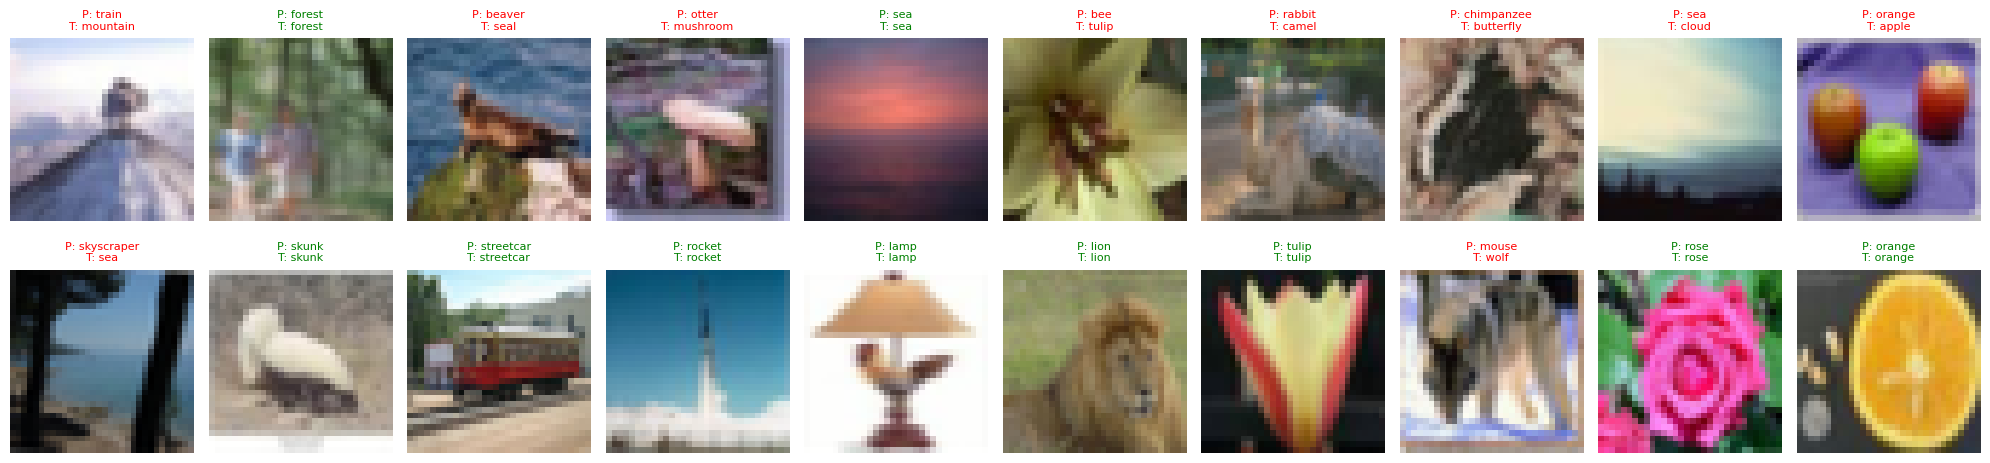

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch

model.eval()
classes = train_dataset.classes
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nAccuracy of the model on the {total} test images: {100 * correct / total:.2f} %')

print("\nVisualizing some predictions...")

dataiter = iter(test_loader)
images, labels = next(dataiter)
images_for_viz = images[:20].to(device)
labels_for_viz = labels[:20].to(device)

# 예측 수행
with torch.no_grad():
    outputs = model(images_for_viz)
    _, predicted = torch.max(outputs, 1)

# 이미지 시각화 함수
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# 예측 결과 시각화
plt.figure(figsize=(20, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    imshow(images_for_viz[i])  # 시각화용 CPU 변환

    predicted_class = classes[predicted[i]]
    true_class = classes[labels_for_viz[i]]
    color = "green" if predicted_class == true_class else "red"

    plt.title(f'P: {predicted_class}\nT: {true_class}', color=color, fontsize=8)

plt.tight_layout()
plt.show()
